In [52]:
# Import Code
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from kneed import KneeLocator
from scipy.optimize import *
import serial
import time
import math
from datetime import datetime as dt
import csv

In [53]:
# Variable declarations
port = 'com19'
baud = 115200

ts = time.localtime() #update time

#Define variables for use
distanceA = list()
distanceB = list()
distanceC = list()
okA = 0
okB = 0
okC = 0
ok = 0
phoneA = 0
phoneB = 1
phoneC = 2

###### CHANGE THIS FOR YOUR DIRECTORY
save_destination = "C:\\Users\\Grego\\LoRa Rescue Data 2\\"

# Distance calculation constants
n = 3.2
dro = 1.5
roRSSI = -32

#Trilateration calculation constants
# GNode Coordinates
# Format: A B C
xg = np.array([0,9.0,-34.0])
yg = np.array([0,196.0,-79.0])
# Actual Node Position
xAct = -24        #Target x-coordinate
yAct = 0          #Target y-coordinat
# For filtering
errorTolerance = 10

In [54]:
# Function Declarations
def listenForData(port,baud):
    #Define variables for use
    arduino = serial.Serial(port, baud)
    distanceA = list()
    distanceB = list()
    distanceC = list()
    okA = 0
    okB = 0
    okC = 0
    ok = 0
    phoneA = 0
    phoneB = 1
    phoneC = 2

    while ok == 0: #will wait until ok is 1. 'ok' will only be 1 when A B C are matching.
        arduino_raw_data = arduino.readline() #read serial data
        decoded_data = str(arduino_raw_data.decode("utf-8")) #convert to utf-8
        data = decoded_data.replace('\n','') #remove \n in the decoded data
        gatewayID = data[:1] #get gateway ID
        dataID = data[1:2] #get data ID
        data = data[2:] #get data
        if gatewayID == 'A':
            filename="gatewayA.csv" #set to write to gatewayA.csv
            if dataID == '1':
                phoneA = data
                print("\nPhone at Gateway A: 0" + phoneA)
            elif dataID == '2':
                distanceA.append(float(data))
            elif dataID == '3':
                # 1) Get time
                ts = time.localtime() #update time
                timeA = time.strftime("%X", ts) #set timeA to current time
                print("timeA: " + timeA)
                dtn = str(dt.now())
                dtn = dtn[0:19]
                dtn = dtn.replace(':',';')
                # 2) Put  distanceA values to distanceAf and clear distanceA for reuse
                distanceAf = distanceA
                del distanceA
                distanceA = list()
                distanceAf = np.delete(distanceAf,len(distanceAf)-1)
                distanceAf = np.delete(distanceAf,len(distanceAf)-1)
                # Convert to distance
                print("RSSI = ")
                print(distanceAf)
                rssiRawA = distanceAf
                distanceAf = distConv(distanceAf)
                print("DistanceAf = ")
                print(distanceAf)
                #print("Length of DistanceAf is: ")
                #print(len(distanceAf))
                okA = 1
                file = open(fileName, "a") #append timedata to the file
                file.write(timeA+"\n") #write timeA to csv file. The 3 is the dataID.
        elif gatewayID == 'B':
            fileName="gatewayB.csv" #set to write to gatewayB.csv
            if dataID == '1':
                phoneB = data
                print("\nPhone at Gateway B: 0" + phoneB)
            elif dataID == '2':
                distanceB.append(float(data))
            elif dataID == '3':
                if phoneB == phoneA:
                    # 1) Set timeB == timeA
                    timeB = timeA
                    print("timeB: " + timeB)
                    # 2) Put  distanceB values to distanceBf and clear distanceB for reuse
                    distanceBf = distanceB
                    del distanceB
                    distanceB = list()
                    distanceBf = np.delete(distanceBf,len(distanceBf)-1)
                    distanceBf = np.delete(distanceBf,len(distanceBf)-1)
                    # Convert to distance
                    print("RSSI = ")
                    print(distanceBf)
                    rssiRawB = distanceBf
                    distanceBf = distConv(distanceBf)
                    print("DistanceBf = ")
                    print(distanceBf)
                    #print("Length of DistanceBf is: ")
                    #print(len(distanceBf))
                    okB = 1
                    file = open(fileName, "a") #append timedata to the file
                    file.write(timeB+"\n") #write timeB to csv file. The 3 is the dataID.
                else:
                    del distanceB
                    distanceB = list()
                    print("phoneB is not the same as phoneA. Data will be discarded.")
        elif gatewayID == 'C':
            fileName="gatewayC.csv" #set to write to gatewayC.csv
            if dataID == '1':
                phoneC = data
                print("\nPhone at Gateway C: 0" + phoneC)
            if dataID == '2':
                distanceC.append(float(data))
            if dataID == '3':
                if phoneC == phoneB == phoneA:
                    # 1) Set timeC == timeB
                    timeC = timeB
                    print("timeC: " + timeC)
                    # 2) Put  distanceB values to distanceBf and clear distanceB for reuse
                    distanceCf = distanceC
                    del distanceC
                    distanceC = list()
                    distanceCf = np.delete(distanceCf,len(distanceCf)-1)
                    distanceCf = np.delete(distanceCf,len(distanceCf)-1)
                    # Convert to distance
                    print("RSSI = ")
                    print(distanceCf)
                    rssiRawC = distanceCf
                    distanceCf = distConv(distanceCf)
                    print("DistanceCf = ")
                    print(distanceCf)
                    #print("Length of DistanceCf is: ")
                    #print(len(distanceCf))
                    okC = 1
                    file = open(fileName, "a") #append timedata to the file
                    file.write(timeC+"\n") #write timeB to csv file. The 3 is the dataID.
                else:
                    del distanceC
                    distanceC = list()
                    print("phoneC is not the same as phoneB and phoneA. Data will be discarded.")
        #Writing to CSV -- Dito nangyayari yung writing to .csv ng Cellphone number and Distance values. Sa taas yung timestamp.
        file = open(fileName, "a") #append the data to the file
        file.write(data) #write data to csv file
        if okA == 1 & okB == 1 & okC == 1:
            ok = 1
            print("\nA, B, and C distances with the same phone number successfully obtained!\n")
        if timeB != timeC:
            print("Error. Time Mismatch.")
            okA = 0
            okB = 0
            okC = 0
            ok = 0
            quit()
    return distanceAf, distanceBf, distanceCf, dtn, phoneA #return the variables

def importCSV():
    distanceAf = list()
    distanceBf = list()
    distanceCf = list()
    with open(save_destination+'gatewayAt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                phoneA = row[1]
            elif line_count > 0 and line_count < 59:
                distanceAf.append(row[1])
            elif line_count == 61:
                dtn = row[1]
                dtn = dtn.replace(':',';')
            line_count += 1
    with open(save_destination+'gatewayBt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count > 0 and line_count < 59:
                distanceBf.append(row[1])
            line_count += 1
    with open(save_destination+'gatewayCt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count > 0 and line_count < 59:
                distanceCf.append(row[1])
            line_count += 1
    return distanceAf, distanceBf, distanceCf, dtn, phoneA

def distConv(rssi):
    dist = list()
    for i in range(int(len(rssi))):
        dist.append(pow(10,((roRSSI-int(rssi[i]))/(10*n)))*dro)
    return dist

def rotateGraph(xg, yg, xAct, yAct):
    def getBcoor(z):
        x = z[0]
        y = z[1]

        F = np.empty((2))
        F[0] = (x**2) + (y**2) - (Rab**2)
        F[1] = ((x-xg[2])**2) + (y**2) - (Rbc**2)
        return F
    def getNcoor(z):
        x = z[0]
        y = z[1]

        F = np.empty((2))
        F[0] = (x**2) + (y**2) - (Ran**2)
        F[1] = ((x-xg[2])**2) + (y**2) - (Rnc**2)
        return F
    zGuess = np.array([1,1])
    if yg[2] != 0:
        notFlat = 1
        xg[2] = -np.sqrt((xg[2]**2)+(yg[2]**2))
        yg[2] = 0
        
        z = fsolve(getBcoor,zGuess)
        xg[1] = z[0]
        yg[1] = -z[1]
        z = fsolve(getNcoor,zGuess)
        xAct = z[0]
        yAct = z[1]
    else:
        notFlat = 0
    return xg, yg, xAct, yAct, notFlat

def trilaterate(distanceAf,distanceBf,distanceCf,xg,yg):
    A = -2*xg[0]+2*xg[1]
    B = -2*yg[0]+2*yg[1]
    C = distanceAf**2-distanceBf**2-xg[0]**2+xg[1]**2-yg[0]**2+yg[1]**2
    D = -2*xg[1]+2*xg[2]
    E = -2*yg[1]+2*yg[2]
    F = distanceBf**2-distanceCf**2-xg[1]**2+xg[2]**2-yg[1]**2+yg[2]**2
    x = (C*E-F*B)/(E*A-B*D)
    y = (C*D-A*F)/(B*D-A*E)
    return x,y

def aveFilter(distanceAf,distanceBf,distanceCf,AfAve,BfAve,CfAve,errorTolerance):
    i = 0
    x = list()
    y = list()
    while i < 60:
        e = 0
        if distanceAf[i] > AfAve + errorTolerance or distanceAf[i] < AfAve - errorTolerance:
            e = 1
        if distanceBf[i] > BfAve + errorTolerance or distanceBf[i] < BfAve - errorTolerance:
            e = 1
        if distanceCf[i] > CfAve + errorTolerance or distanceCf[i] < CfAve - errorTolerance:
            e = 1
        if e != 0:
            distanceAf = np.delete(distanceAf,i)
            distanceBf = np.delete(distanceBf,i)
            distanceCf = np.delete(distanceCf,i)
            if i == len(distanceAf)-1:
                i = 60
                return distanceAf, distanceBf, distanceCf
                continue
        dA = distanceAf[i]
        dB = distanceBf[i]
        dC = distanceCf[i]
        i += 1
        if i == len(distanceAf)-1:
            return distanceAf, distanceBf, distanceCf
            break

In [55]:
# Listen to COM port and check for errors
# distanceAf, distanceBf, distanceCf, dtn, phoneA = listenForData(port,baud)
# For testing import CSVs from gatewayAt etc.
distanceAf, distanceBf, distanceCf, dtn, phoneA = importCSV()

In [56]:
# Trilateration Part of the Code
for i in range(len(distanceAf)):
    distanceAf[i] = float(distanceAf[i])
    distanceBf[i] = float(distanceBf[i])
    distanceCf[i] = float(distanceCf[i])
# Convert Distances from each GNode to numpy arrays
distanceAf = np.array(distanceAf)
distanceBf = np.array(distanceBf)
distanceCf = np.array(distanceCf)
# Get average distances
AfAve = sum(distanceAf)/len(distanceAf)
BfAve = sum(distanceBf)/len(distanceBf)
CfAve = sum(distanceCf)/len(distanceCf)

# Rotate Graph, comment if not needed
# xg, yg, xAct, yAct, notFlat = rotateGraph(xg, yg, xAct, yAct)

# Ave Filter Data
dFilteredA, dFilteredB, dFilteredC = aveFilter(distanceAf,distanceBf,distanceCf,AfAve,BfAve,CfAve,errorTolerance)

# Trilaterate Data
print("The program is now trilaterating...\n")
x,y = trilaterate(distanceAf,distanceBf,distanceCf,xg,yg)
xAve,yAve = trilaterate(AfAve,BfAve,CfAve,xg,yg)
xFilt,yFilt = trilaterate(dFilteredA,dFilteredB,dFilteredC,xg,yg)

The program is now trilaterating...



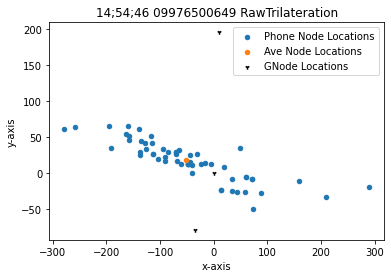

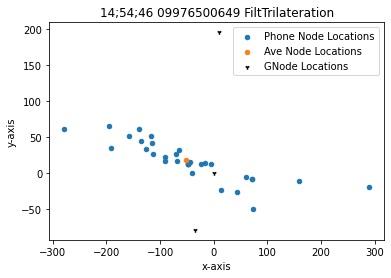

In [57]:
# Plot the data for trilateration w/o the filters
plt.figure(1)
plt.scatter(x, y, label='Phone Node Locations', cmap='brg', s=20)
plt.scatter(xAve, yAve, label='Ave Node Locations', cmap='brg', s=20)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=20)
plt.title(dtn + ' 0' + phoneA  + ' RawTrilateration')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' RawTrilateration.jpg')
# Plot the data for trilateration w/o the filters
plt.figure(2)
plt.scatter(xFilt, yFilt, label='Phone Node Locations', cmap='brg', s=20)
plt.scatter(xAve, yAve, label='Ave Node Locations', cmap='brg', s=20)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=20)
plt.title(dtn + ' 0' + phoneA  + ' FiltTrilateration')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' FiltTrilateration.jpg')

In [ ]:
# K-means
# FUNCTION [4]
for i in range(1,len(data)):
    kmeans = KMeans(n_clusters=i).fit(data)
    inertia.append(kmeans.inertia_)

#Determine optimal Number of Clusters based on Elbow
elbow = KneeLocator(range(1,len(data)),inertia, curve='convex', direction='decreasing')

print('Optimal Number of Clusters is', elbow.knee)
kmeans = KMeans(n_clusters=elbow.knee, n_init=5).fit(data) #Perform K-means with elbow no. of clusters
# FUNCTION [4 = kmeans,intertia,elbow.knee]

In [ ]:
#Elbow Plot
plt.figure(2)
plt.plot(range(1,len(data)), inertia)
plt.xlabel('No. of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title(dtn + ' 0' + phoneA[0:len(phoneA)-1]  + ' Elbow Graph')
plt.savefig(save_destination + dtn + ' 0' + phoneA[0:len(phoneA)-1] + ' Elbow.jpg') #Change Directory Accordingly

# K-means Plot
plt.figure(3)
plt.scatter(data[:,0],data[:,1], c=kmeans.labels_, label = 'Phone Node Locations', cmap='brg', s=5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c=list(range(1,elbow.knee+1)), marker = 'x', label = 'Cluster Centers', cmap='brg', s=30)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=30)
plt.scatter(xAve, yAve, marker='^', label='Average Point', c='black', s=30)
plt.scatter(xAct, yAct, marker='*', label='Actual Point', c='green', s=30)
plt.grid(linewidth=1, color="w")
ax = plt.gca()
ax.set_facecolor('gainsboro')
ax.set_axisbelow(True)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title(dtn + ' 0' + phoneA[0:len(phoneA)-1]  + ' K-Means')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA[0:len(phoneA)-1] + ' K-Means.jpg') #Change Directory Accordingly

In [ ]:
# Error Computations
# Computed Position vs. Actual Position
# FUNCTION [5]
compVact = list()
for i in range(len(x)):
    compVact.append(np.sqrt((x[i]-xAct)**2+(y[i]-yAct)**2))

#Computed distanceAf, Bf, Cf
comp_distanceAf = list()
comp_distanceBf = list()
comp_distanceCf = list()
comp_distanceAf = np.sqrt((xAct**2)+(yAct**2))
comp_distanceBf = np.sqrt(((xAct-xg[1])**2)+((yAct-yg[1])**2))
comp_distanceCf = np.sqrt(((xAct-xg[2])**2)+((yAct-yg[2])**2))

#K-means centroid vs. Average Point (dataset average)
centVave = np.sqrt((kmeans.cluster_centers_[:,0]-xAve)**2+(kmeans.cluster_centers_[:,1]-yAve)**2)

#Computed Position vs. K-means centroid
compVcent = np.sqrt([(data[:,0]-kmeans.cluster_centers_[0,0])**2+(data[:,1]-kmeans.cluster_centers_[0,1])**2])
for i in range(1,len(kmeans.cluster_centers_)):
    distance = np.sqrt([(data[:,0]-kmeans.cluster_centers_[i,0])**2+(data[:,1]-kmeans.cluster_centers_[i,1])**2])
    compVcent = np.append(compVcent,distance,axis=0)
# FUNCTION [5]

In [ ]:
###############CSV Writing############
with open(save_destination+'Recompute.csv', mode='a') as logs:
    logswrite = csv.writer(logs, dialect='excel', lineterminator='\n')
    logswrite.writerow(['Actual Position','',xAct,yAct])
    logswrite.writerow(['gnodeA','gnodeB','gnodeC'])
    logswrite.writerows([[np.append(xg[0],yg[0]), np.append(xg[1],yg[1]), np.append(xg[2],yg[2])]])
    logswrite.writerow(['Computed Distances from Gnodes'])
    logswrite.writerow(['A','B','C'])
    logswrite.writerow([comp_distanceAf,comp_distanceBf,comp_distanceCf])
    logswrite.writerow(['Average Points'])
    logswrite.writerow(['A','B','C','','Xave','Yave'])
    logswrite.writerow([AfAve,BfAve,CfAve,'',xAve,yAve])
    logswrite.writerow(['K-Means Centroids vs. Average Point'])
    logswrite.writerows([centVave])
    logswrite.writerow(['Optimal # of Clusters','','',elbow.knee])
    logswrite.writerow(['Time','Phone#','Ra','Rb','Rc','','Xcomp','Ycomp','I','MSE'])
    for i in range(len(unformattedX)):
        if i < len(inertia):
            logswrite.writerow([dtn,'0'+phoneA[0:len(phoneA)-1],distanceAf[i],distanceBf[i],distanceCf[i],'',x[i],y[i],inertia[i],compVact[i]])
        elif i >= len(inertia) and i <len(compVact):
            logswrite.writerow([dtn,'0'+phoneA[0:len(phoneA)-1],distanceAf[i],distanceBf[i],distanceCf[i],'',x[i],y[i],'',compVact[i]])
        else: 
            logswrite.writerow([dtn,'0'+phoneA[0:len(phoneA)-1],distanceAf[i],distanceBf[i],distanceCf[i]])

    logswrite.writerow(['Computed Position vs. K-means Centroid:'])
    rangeof_compVcent = compVcent[:,1]
    for i in range(len(rangeof_compVcent)):
        logswrite.writerows([compVcent[i,:]])
    logswrite.writerow([''])
    logswrite.writerow([''])